# Task

English - Dutch (Domain Specific)

#### Going thourgh the validation data

The text conatins 
1. non-natural language text
2. Characters like {1}, {2}....
3. Units like 30W, 64MP
4. Companies like TurboPower^(TM)

#### 1. Training Dataset - WMT 2016 EN-Dutch
#### 2. General domain evaluation - FLORES devtest
#### 3. Validation - Dataset_challenge_1.xlsx

## Proposed Steps
1. Start with pretrained EN-Dutch translation model
2. Finetune on WMT 2016 dataset to adpot it to the IT domain
3. Preprocessing text to preserve the characters in validation set
4. Validate general domain translation on FLORES dataset
5. Validate excel dataset for IT domain

The idea is to build a robust pipeline starting with the encoder-decoder model containing data loading, model training, model evaluation using both the methods FLORES and the excel dataset then robustness of the pipeline should let us swap the model and train the decoder-only model. This will let us identify bugs faster in the decoder-only model and identify inconsistencies
Dataset loading, Train/val/test split, evaluation methods stays fixed in the pipeline for both the problems

### Step 1 - Working on the WMT dataset

Looking at the website (https://www.statmt.org/wmt16/it-translation-task.html)
I choose out-of-domain training data - Europarl corpus

The reason for using this is that we train the model to evaluate if domain adaptaion is achieved from finetuning rather than training it on IT specific data for the model to memorize the data

In [11]:
from pathlib import Path
import statistics

In [ ]:
def inspect_parallel_corpus(en_path, nl_path, sample_k=5):
    en_lines = Path(en_path).read_text(encoding="utf-8").splitlines()
    nl_lines = Path(nl_path).read_text(encoding="utf-8").splitlines()

    print(f"Number of English lines: {len(en_lines)}")
    print(f"NNumer of Dutch lines:   {len(nl_lines)}")
    assert len(en_lines) == len(nl_lines), "The numbers dont match"
    print()

    en_lengths = [len(l.split()) for l in en_lines if l.strip()]
    nl_lengths = [len(l.split()) for l in nl_lines if l.strip()]

    print("----Lengths----")
    print(f"EN avg/median: {statistics.mean(en_lengths):.1f}/{statistics.median(en_lengths)}")
    print(f"NL avg/median: {statistics.mean(nl_lengths):.1f}/{statistics.median(nl_lengths)}")
    print(f"EN max length: {max(en_lengths)}")
    print(f"NL max length: {max(nl_lengths)}")
    print()

    empty_en = sum(1 for l in en_lines if not l.strip())
    empty_nl = sum(1 for l in nl_lines if not l.strip())
    print("-----Empty lines-----")
    print(f"Empty EN lines: {empty_en}")
    print(f"Empty NL lines: {empty_nl}")
    print()

    print("--- Sample sentence pairs ---")
    for i in range(sample_k):
        print(f"EN: {en_lines[i]}")
        print(f"NL: {nl_lines[i]}")

In [ ]:
en_path="data/nl-en/europarl-v7.nl-en.en"
nl_path="data/nl-en/europarl-v7.nl-en.nl"

In [28]:
inspect_parallel_corpus(
    en_path=en_path,
    nl_path=nl_path
)

Number of English lines: 1997775
NNumer of Dutch lines:   1997775

----Lengths----
EN avg/median: 25.0 / 22
NL avg/median: 25.4 / 23
EN max length: 668
NL max length: 583

-----Empty lines-----
Empty EN lines: 15638
Empty NL lines: 3392

--- Sample sentence pairs ---
EN: Resumption of the session
NL: Hervatting van de zitting
EN: I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
NL: Ik verklaar de zitting van het Europees Parlement, die op vrijdag 17 december werd onderbroken, te zijn hervat. Ik wens u allen een gelukkig nieuwjaar en hoop dat u een goede vakantie heeft gehad.
EN: Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.
NL: Zoals u heeft kunnen constateren, is de grote "millenniumbu

1. The line pairs match
2. Avg length and Median length looks fine around 25
3. Max length is around 600 (should look into this model might not support)
4. Lot of empty lines

TODO:
1. Remove empty sentence pairs
2. Filter by max length
3. Fix a number for finetuning hardware limitation for around 2M pairs

In [29]:
from pathlib import Path
import random

In [30]:
def load_parallel(en_path, nl_path):
    en_lines = Path(en_path).read_text(encoding="utf-8").splitlines()
    nl_lines = Path(nl_path).read_text(encoding="utf-8").splitlines()
    assert len(en_lines) == len(nl_lines)
    return list(zip(en_lines, nl_lines))


def filter_pairs(pairs, max_len=128, min_len=3):
    filtered = []
    for en, nl in pairs:
        if not en.strip() or not nl.strip():
            continue

        en_len = len(en.split())
        nl_len = len(nl.split())

        if en_len < min_len or nl_len < min_len:
            continue
        if en_len > max_len or nl_len > max_len:
            continue

        filtered.append((en, nl))
    return filtered


def subsample_and_split(pairs, total_size=200_000, val_size=10_000, seed=42):
    random.seed(seed)
    random.shuffle(pairs)

    pairs = pairs[:total_size]
    train = pairs[:-val_size]
    val = pairs[-val_size:]

    return train, val

In [36]:
pairs = load_parallel(
    en_path,
    nl_path
)

print(f"num original pairs: {len(pairs)}")

filtered_pairs = filter_pairs(pairs)
print(f"num after filtering: {len(filtered_pairs)}")
print()

train_pairs, val_pairs = subsample_and_split(filtered_pairs)

print(f"train size: {len(train_pairs)}")
print(f"val size:   {len(val_pairs)}")

num original pairs: 1997775
num after filtering: 1959526

train size: 190000
val size:   10000


In [13]:
en_path="data/nl-en/europarl-v7.nl-en.en"
nl_path="data/nl-en/europarl-v7.nl-en.nl"

train_path_en = "data/train.en"
val_path_en = "data/val.en"

train_path_nl = "data/train.nl"
val_path_nl = "data/val.nl"

In [ ]:
def save_pairs(pairs, out_en, out_nl):
    Path(out_en).write_text("\n".join(p[0] for p in pairs), encoding="utf-8")
    Path(out_nl).write_text("\n".join(p[1] for p in pairs), encoding="utf-8")

save_pairs(train_pairs, train_path_en, train_path_nl)
save_pairs(val_pairs, val_path_en, val_path_nl)

1. Setting max length to 128 because most small models support only upto 128 tokens only around 40000 lines are skipped so that shouldn't be an issue
2. Sampling 190k pairs for training and 10k for validation should be enough to finetune a small encoder-decoder model
3. Saved the train and val data

### Step 2 - Working on the Encoder-Decoder model


1. Choose the encoder-decoder base model

1a - from Europarl the average length is 25 words 

1b - we have sentence level parallel data

1c - We can choose MarianMT as our base model

1ci - small enough to fine tune on arond 200k pairs

1cii - Trained specifically on EN-Dutch language

1ciii - Already trained on Europarl

1civ - Since it is already trained on Europarl we are continually finetuning to shift hte model's behavior, we are shifiting the model's domain instead of teach the model from start

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import MarianMTModel, MarianTokenizer
import wandb

In [24]:
class TranslationDataset(Dataset):
    def __init__(self, src_file, tgt_file, tokenizer, max_len=128):
        self.src = open(src_file, encoding="utf-8").read().splitlines()
        self.tgt = open(tgt_file, encoding="utf-8").read().splitlines()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src = self.tokenizer(
            self.src[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        tgt = self.tokenizer(
            self.tgt[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )

        labels = tgt["input_ids"]
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": src["input_ids"].squeeze(),
            "attention_mask": src["attention_mask"].squeeze(),
            "labels": labels.squeeze(),
        }

In [19]:
wandb.init(
    project="English-Dutch-MT",
    config={
        "model": "Helsinki-NLP",
        "lr": 2e-5,
        "batch_size": 16,
        "max_len": 128,
        "epochs": 3,
    },
)

In [25]:
from torch.optim import AdamW

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "Helsinki-NLP/opus-mt-en-nl"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name).to(device)

optimizer = AdamW(model.parameters(), lr=wandb.config.lr)

c:\Users\ganesh\Desktop\Revanth\Assignment\LLM company\rough_env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [27]:
batch_size = 16
num_epochs = 3

In [28]:
train_ds = TranslationDataset(train_path_en, train_path_nl, tokenizer)
val_ds = TranslationDataset(val_path_en, val_path_nl, tokenizer)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)

In [30]:
for each_epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = {
            k: v.to(device) for k, v in batch.items()
        }

        outputs = model(**batch)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    wandb.log({
        "train_loss": avg_train_loss,
        "lr": optimizer.param_groups[0]["lr"],
        "epoch": each_epoch
    })

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            batch = {
                k: v.to(device) for k, v in batch.items()
            }

            outputs = model(**batch)
            loss = outputs.loss

            val_loss += loss.item()
        
    avg_val_loss = val_loss/len(val_loader)
    wandb.log({
        "val_loss": avg_val_loss,
    })

    print(f"epoch {each_epoch}, train loss: {avg_train_loss}, val loss: {avg_val_loss}")

epoch 0, train loss: 1.3439366612785741, val loss: 0.9585955175399781
epoch 1, train loss: 0.9716918534680417, val loss: 0.8753711093902588
epoch 2, train loss: 0.8807454771242643, val loss: 0.8412576155662537


In [ ]:
model.save_pretrained("finetuned-marian-en-nl")
tokenizer.save_pretrained("finetuned-marian-en-nl")
wandb.finish()

#### These are the model training metrics from wandb

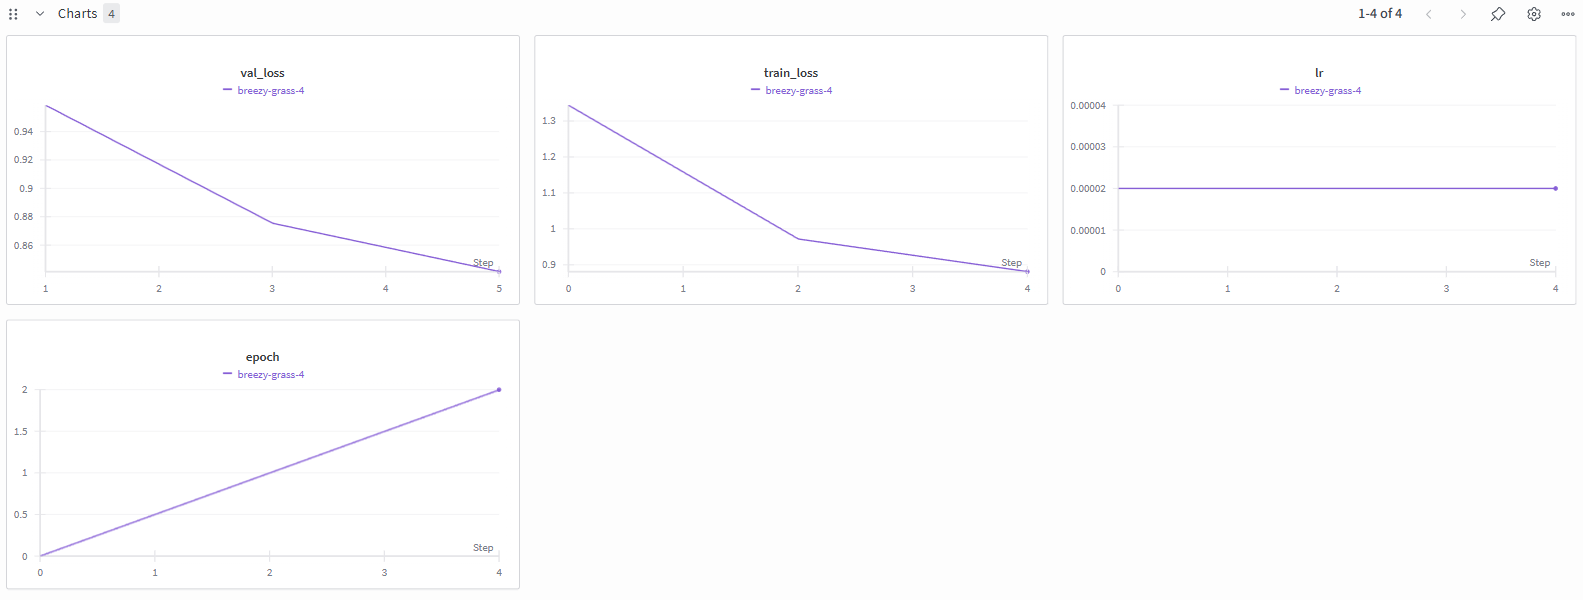

#### Evaluating the model

In [1]:
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd
import sacrebleu

In [2]:
model_name = "finetuned-marian-en-nl"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

c:\Users\ganesh\Desktop\Revanth\Assignment\LLM company\rough_env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
def translate(text, max_len=128):
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        truncation=True, 
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        generated = model.generate(
            **inputs,
            max_length=max_len,
            num_beams=4
        )

    return tokenizer.decode(generated[0], skip_special_tokens=True)

In [27]:
def evaluate(model, x_sentences, gt_sentences):
    all_predictions = []

    for i, text in enumerate(x_sentences):
        translation = translate(text)
        all_predictions.append(translation)

    refs_list = gt_sentences
    bleu = sacrebleu.corpus_bleu(all_predictions, refs_list, tokenize="flores200")
    chrf = sacrebleu.corpus_chrf(all_predictions, refs_list, word_order=2)
    ter = sacrebleu.corpus_ter(all_predictions, refs_list)

    print(f"SacreBLEU: {bleu.score:.2f}")
    print(f"chrF++:    {chrf.score:.2f}")
    print(f"TER:       {ter.score:.2f}")

In [5]:
def load_flores(flores_path):
    en_df = pd.read_parquet(flores_path+"eng_Latn.parquet", engine="fastparquet")
    nl_df = pd.read_parquet(flores_path+"nld_Latn.parquet", engine="fastparquet")

    x_sentences = en_df["text"].tolist()
    gt_sentences = nl_df["text"].tolist()
    return x_sentences, gt_sentences

In [30]:
def load_challenge_excel(csv_path):
    df = pd.read_excel(csv_path)
    return df['English Source'].tolist(), df['Reference Translation'].tolist()

In [ ]:
x_sentences, gt_sentences = load_flores("data/flores/")
evaluate(x_sentences, gt_sentences)

SacreBLEU: 0.05
chrF++:    7.34
TER:       3003.71


In [31]:
x_sentences, gt_sentences = load_challenge_excel("Dataset_Challenge_1.xlsx")
evaluate(model, x_sentences, gt_sentences)

SacreBLEU: 0.18
chrF++:    5.83
TER:       963.06


# Validation on the excel dataset

Okay so the model training is done took around 4hrs and lets check if the model does any better than the base model

In [51]:
from transformers import MarianMTModel, MarianTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "finetuned-marian-en-nl"
tokenizer = MarianTokenizer.from_pretrained(model_path)
model = MarianMTModel.from_pretrained(model_path).to(device)
model.eval()

model_name = "Helsinki-NLP/opus-mt-en-nl"
tokenizer = MarianTokenizer.from_pretrained(model_name)
base_model = MarianMTModel.from_pretrained(model_name).to(device)
base_model.eval()

c:\Users\ganesh\Desktop\Revanth\Assignment\LLM company\rough_env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


MarianMTModel(
  (model): MarianModel(
    (shared): Embedding(67028, 512, padding_idx=67027)
    (encoder): MarianEncoder(
      (embed_tokens): Embedding(67028, 512, padding_idx=67027)
      (embed_positions): MarianSinusoidalPositionalEmbedding(512, 512)
      (layers): ModuleList(
        (0-5): 6 x MarianEncoderLayer(
          (self_attn): MarianAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation_fn): SiLU()
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (final_layer_norm): LayerNorm((512,), eps=1e-05

In [2]:
def translate(text, model, max_len=128):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        generated = model.generate(
            **inputs,
            max_length=max_len,
            num_beams=4
        )

    return tokenizer.decode(generated[0], skip_special_tokens=True)

In [56]:
# df = pd.read_excel("Dataset_Challenge_1.xlsx")

finetuned_translations = [translate(x, model) for x in df['English Source']]
base_translations = [translate(x, base_model) for x in df["English Source"]]

df["finetuned_translations"] = finetuned_translations
df["base_translations"] = base_translations

NOPE - The model performs prettymuch as same as the base model and worse in few cases based on looking at few examples and the evaluation results <br>
Which is again expected I guess, the model has no gradient signals how to translate {1} or built-inUFS spacing <br>
Finetuning on out of domain data alone isnt enough to adapt the translation to the required domain<br>
In few cases like {1} the base model does better than the finetuned model

What to do next? <br>
We can go about in 2 ways <br>
1. Freeze encoder and finetune only the decoder for lower learning rate and fewer epochs - this can reduce the domain overshifting problem we are observing above - I cannot do this because of the time constraint<br>

2. Try preprocessing the test data and build guard rails for expected patterns that has to be preserved and the ones which won't probably present in the training dataset <br>
Add masks over the text the model will probably not recognize and unmask after generation

In [ ]:
import re

PLACEHOLDER_PATTERN = re.compile(r"\{\d+\}")
SYMBOL_PATTERN = re.compile(r"[™®]")

In [ ]:
def mask_text(text):
    mappings = {}
    counter = 0

    def _replace(match):
        nonlocal counter
        key = f"<MASK{counter}>"
        mappings[key] = match.group(0)
        counter += 1
        return key

    text = PLACEHOLDER_PATTERN.sub(_replace, text)
    text = SYMBOL_PATTERN.sub(_replace, text)

    return text, mappings

In [ ]:
def unmask_text(text, mappings):
    for k, v in mappings.items():
        text = text.replace(k, v)
    return text

In [10]:
def translate_mask(text, model, max_len=128):
    masked_text, mappings = mask_text(text)

    inputs = tokenizer(
        masked_text,
        return_tensors="pt",
        truncation=True,
        max_length=max_len
    ).to(device)

    with torch.no_grad():
        generated = model.generate(
            **inputs,
            num_beams=4,
            max_length=max_len
        )

    decoded = tokenizer.decode(generated[0], skip_special_tokens=True)
    return unmask_text(decoded, mappings)

In [42]:
MASK_TOKENS = [f"<MASK{i}>" for i in range(100)]

tokenizer.add_tokens(MASK_TOKENS)
model.resize_token_embeddings(len(tokenizer))
base_model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(67128, 512, padding_idx=67027)

In [43]:
df = pd.read_excel("Dataset_Challenge_1.xlsx")

finetuned_translations_masked = [translate_mask(x, model) for x in df['English Source']]
base_translations_masked = [translate_mask(x, base_model) for x in df["English Source"]]

df["finetuned_translations_masked"] = finetuned_translations_masked
df["base_translations_masked"] = base_translations_masked

In [47]:
df.to_excel('translations.xlsx', index=False)

Somehow the finetuned model is removing the <MASK> tokens, hypothesis is that the finetuned model has learned to remove unknown tokens but the base model keeps it intact <br>
Fix would be to mask the training data and then finetune the model again but with the interest of time, I couldn't do it

In [57]:
df.head()

,English Source,Reference Translation,finetuned_translations_masked,base_translations_masked,finetuned_translations,base_translations
0,"256GB built-inUFS 3.1 + LPDDR5""",256 GB ingebouwdUFS 3.1 + LPDDR5,"Ingebouwde zin 3,1 + LPDDR5""","256GB ingebouwdeUFS 3.1 + LPDDR5""","256GB bouwbedrijven 3,1 + LPDDR5""","256GB ingebouwde HUF's 3.1 + LPDDR5"""
1,Snap crystal-clear photos and selfies in any l...,Maak kristalheldere foto's en selfies bij elk ...,Stelt u glasheldere foto's en zelfieën in iede...,Snap kristalheldere foto's en selfies in elk l...,Stelt u glasheldere foto's en egoïnen in elk l...,Snap kristalheldere foto's en selfies in elk l...
2,30W TurboPower™ charging support*sold separate...,Ondersteuning voor TurboPower™ laden met 30 W{...,schriftelijk. - (PT) De lidstaten van de Commi...,30W TurboPower™ laadondersteuning* afzonderlij...,30W turboPowerTM-opladingssteunafzonderlijk ve...,30W TurboPowerTM laadondersteuning* afzonderli...
3,{1}Update window: From {2} to {3},{1}Updateperiode: van {2} tot {3},schriftelijk. - (NL),{1}Venster bijwerken: Van {2} naar {3},Venster (1]Update: van (2] tot (3],{1}Venster bijwerken: van {2} naar {3}
4,Or leave now and get a reminder.,Of sluit af en ontvangen een herinnering.,Of vertrek nu en krijg een herinnering.,Of vertrek nu en vraag om een herinnering.,Of vertrek nu en krijg een herinnering.,Of vertrek nu en vraag om een herinnering.


# Part 3 of the assignment

I am going to train the model not here but by using the pipeline I built for the above 2 parts of the assignment <br>
The plan is to use instruction tuning, and I choose GPT-2 for the base model choice since that's what the claim is on the GPT paper "Language Models are Few-Shot Learners"

I need to change the pipeline to accomodate the decoder model and make the piepeline robust enough to handle both encoder decoder and decoder only models <br> 
You can look at the commit history to get the incremental updates to the pipeline throught the assignment <br>

The idea is everything should be handled through the config.yaml file

The method I am using for the decoder only file tuning is instruction tuning, masking the input, instructions and only using the target gradients as update signals for the model parameters.

Metrics for FLORES dataset <br>

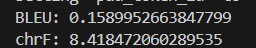 <br>

Metrics for excel dataset <br>

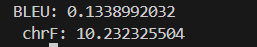

The metrics are as expected, doing decently on FLORES dataset and worse in the excel dataset